# Training a commute prediction network, and visualizing learning!  
<ul> latest version available from: https://github.com/miroenev/teach_DL , prerequisites:
* Matplotlib, Numpy, MxNet, and <a href="https://github.com/K3D-tools/K3D-jupyter">K3D</a> for realtime training 3D surface visualization

A video walkthrough of this notebook is <a href='https://youtu.be/HgbGJn9yz30'> available on YouTube</a>.

In [ ]:
!pip install ipywidgets ipydatawidgets k3d
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py --sys-prefix k3d
!jupyter nbextension enable --py --sys-prefix k3d

In [1]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import k3d as K3D

#set default figure size
plt.rcParams['figure.figsize'] = [9.5, 5]

In [2]:
%matplotlib notebook

In [3]:
import mxnet as mx

# Define the problem

Lets try to predict commute duration from two observable independent variables: the time of day and the weather conditions.

<img src='figures/commute.png' width='400'/>
<img src='figures/target_distribution.PNG' width='1000'/>
In this toy example we'll first take on the role of the 'traffic gods' and decree that commute duration is defined through a linear mixture of the two independent variables. Later we'll sample from the distribution defined by these variables and generate a training dataset. This sampling procedure will be analogous to keeping a journal of all of our commutes for some [ long ] period of time, where each log entry consists of a set of  
* <b>X</b>: [ time-of-departure, weather-condition ], and the associated  
* <b>Y</b>: [ commute-duration ].

<img src='figures/x_y_mapping.PNG' width='900'/>

Given such a journal [dataset], we'll split it into training (75%) and testing (25%) subsets which we'll use to train and evaulate our model respectively. Specifically, we'll build a neural network model whose weights are initially randomly initialized, but are trained/updated as we stream the training data through (via the backpropagation learning algorithm). Each update will get us closer to having a model that has learned the relationship between X and Y or ([ time-of-departure, weather-condition ] to [ commute-duration] ).

<img src='figures/process.PNG' width='800'/>

During the training process we'll try to visualize the network's behavior by asking it to predict all the entries in our logbook using its current parameters/weights. As the training process unfolds, you should be able to see how the network adapts itself to the target surface/function that we determined for the commute duration.

<img src='figures/training_progress.PNG' width='700'/>

# Determine underlying relationship
We'll start by esablishing (as traffic gods) the relationships between:  
* 1) the time a commute starts (time-of-departure variable) and commute-duration
* 2) the weather when a commute is started (weather-condtion variable) and commute-duration

Note that as data scientists we never get to see this function, but we try to learn it from data.

In [4]:
# define data coordinates
xRange = [0,10]; 
yRange = [0,10]; numSteps = 100

x, y = np.meshgrid( np.linspace(xRange[0], xRange[1], numSteps),
                    np.linspace(yRange[0], yRange[1], numSteps), indexing='ij' )

def normalize_domain (x):
    x = x + np.abs(np.min(x))
    x = x / (np.max(x) + .001)
    return x
    
# define 1D relationships to target
xComponent = np.sin( x ) * 4
yComponent = np.exp( y / 4 )

# define 2D joint distribution
z = xComponent + yComponent
z = normalize_domain(z)

In [5]:
#kPlot = K3D.plot()
#kPlot.surface(z)

<IPython.core.display.Javascript object>


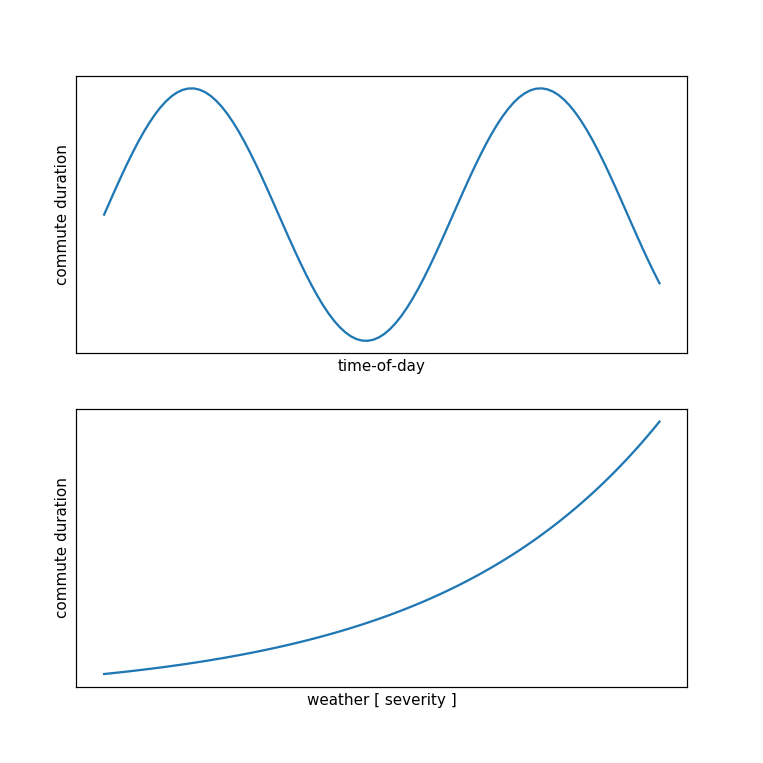

<IPython.core.display.Javascript object>


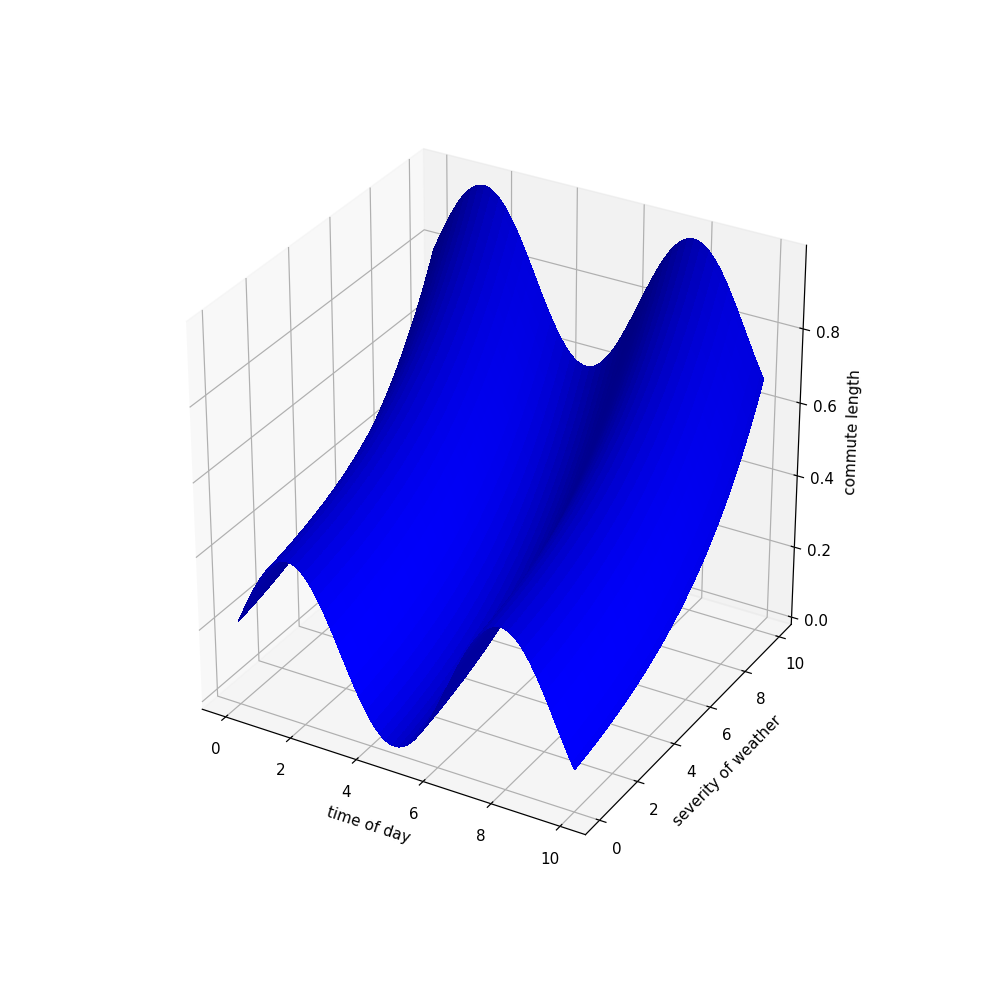

In [6]:
# plot independent variables
plt.figure( figsize = ( 7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1, wspace = 0.2 )
plt.subplot(2,1,1); plt.plot(normalize_domain(xComponent[:,0])); plt.xlabel('time-of-day'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2); plt.plot(normalize_domain(yComponent[0,:])); plt.xlabel('weather [ severity ]'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])

# plot target [dependent] variable
plt.figure( figsize = (9, 9) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
ax = plt.subplot(1,1,1, projection='3d');
ax.plot_surface ( x[0::1], y[0::1], z[0::1], color = 'blue', alpha = 1, antialiased = False )
ax.set_xlabel('time of day')
ax.set_ylabel('severity of weather')
ax.set_zlabel('commute length')
plt.show()

# Generate  dataset
Lets generate a dataset by randomly sampling from the target distribution [ with some noise ].

In [7]:
NSamples = 5000
noiseScaling = 1/8.

gpu_device=mx.gpu()

shuffledDataIndsX = np.random.randint(x.shape[0], size=(NSamples,1))
shuffledDataIndsY = np.random.randint(y.shape[0], size=(NSamples,1))

trainData = np.zeros( ( NSamples, 2 ) )
targetValues = np.zeros( (NSamples, 1 ))
noiseAmount = noiseScaling * ( np.random.rand(NSamples) - .5 )

for iSample in range (NSamples):
    trainData[iSample, 0] = x[ shuffledDataIndsX[iSample], 0 ]
    trainData[iSample, 1] = y[ 0, shuffledDataIndsY[iSample] ]    
    targetValues[iSample] = z[ shuffledDataIndsX[iSample], shuffledDataIndsY[iSample] ] + noiseAmount[iSample]

trainDataGPU = mx.nd.array(trainData, ctx=gpu_device)
targetValuesGPU = mx.nd.array(targetValues, ctx=gpu_device)

# Plot dataset samples (red dots) overlayed onto target distribution (blue)

In [8]:
z.shape

(100, 100)

In [11]:
!KERAS_BACKEND=mxnet
!pip install ipywidgets ipydatawidgets k3d
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py --sys-prefix k3d
!jupyter nbextension enable --py --sys-prefix k3d

mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Installing /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/k3d/static -> k3d
Up to date: /home/ec2-user/anaconda3/envs/mxnet_p36/share/jupyter/nbextensions/k3d/784d74aa347f488ff5cb.worker.js.map
Up to date: /home/ec2-user/anaconda3/envs/mxnet_p36/share/jupyter/nbextensions/k3d/index.js
Up to date: /home/ec2-user/anaconda3/envs/mxnet_p36/share/jupyter/nbextensions/k3d/index.js.map
Up to date: /home/ec2-user/anac

Enabling notebook extension k3d/extension...
      - Validating: OK


In [12]:
def plot_3D_data (k3dPlot):
    zScaling = 5

    offset = np.hstack( ( np.ones((trainData.shape[0], 1)) * -5, 
                          np.ones((trainData.shape[0], 1)) + 4, 
                          np.zeros((trainData.shape[0], 1)) ) ) * np.abs(xRange[1]-xRange[0])

    k3dPlot += k3d.points ( np.hstack( ( trainData, targetValues*zScaling) ) + offset, color=0xFF0000, point_size = .2, shader = 'flat' )
    
    k3dPlot += k3d.surface ( np.rot90(z,3)*zScaling, color=0x0055FF, 
                            xmin=np.min(trainData[:,0]+offset[::,0]), 
                            xmax=np.max(trainData[:,0]+offset[::,0]), 
                            ymin=np.min(trainData[:,1]+offset[::,1]), 
                            ymax=np.max(trainData[:,1]+offset[::,1]))
    return zScaling, offset

plot = k3d.plot()
_, _ = plot_3D_data(plot)
plot.display()

Output()

# Create Data Iterators

In [50]:
data = trainDataGPU
label = targetValuesGPU[:,0]

trainIterator = mx.io.NDArrayIter( data = data, label = label, 
                                   data_name = 'data', 
                                   label_name = 'linearOutput_label', batch_size = 256)

predictIterator = mx.io.NDArrayIter( data = data, label = label, 
                                     data_name = 'data', 
                                     label_name = 'linearOutput_label', batch_size = NSamples)


# Define model structure

In [51]:
import mxnet as mx

inputData = mx.sym.Variable('data')
targetLabelVar = mx.sym.Variable('linearOutput_label') 

layer1 = mx.sym.FullyConnected( data = inputData, name = 'fc1', num_hidden = 5)
layer1Activation = mx.sym.Activation( data = layer1, name = 'sig1', act_type = "sigmoid")

layer2 = mx.sym.FullyConnected( data = layer1Activation, name='fc2', num_hidden = 27)
layer2Activation = mx.sym.Activation( data = layer2, name='sig2', act_type = "sigmoid")

layer3 = mx.sym.FullyConnected( data = layer2Activation, name='fc3', num_hidden = 20)
layer3Activation = mx.sym.Activation( data = layer3, name='sig3', act_type = "sigmoid")

layer4 = mx.sym.FullyConnected( data = layer3Activation, name = 'fc4', num_hidden = 40)
layer4Activation = mx.sym.Activation( data = layer4, name = 'sig4', act_type = "sigmoid")

output = mx.sym.FullyConnected( data = layer4Activation, name='output', num_hidden=1)

loss = mx.sym.LinearRegressionOutput( data = output, label = targetLabelVar , name = 'linearOutput_label')

In [52]:
mod = mx.mod.Module(symbol = loss,
                    context = mx.gpu(0),
                    data_names = ['data'],
                    label_names = ['linearOutput_label'])

In [53]:
# allocate memory given the input data and label shapes
mod.bind( data_shapes = trainIterator.provide_data, label_shapes = trainIterator.provide_label )

In [54]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [55]:
# use adam optimizer
mod.init_optimizer( optimizer = 'adam' )

In [56]:
# use root mean squared error as the metric
metric = mx.metric.create( 'rmse' )

# Visualize network structure

In [57]:
# mx.viz.plot_network( loss )

In [58]:
import importlib
import sys
sys.path.append('utils')
import nnViz_mxnet
importlib.reload(nnViz_mxnet)

<module 'nnViz_mxnet' from 'utils/nnViz_mxnet.py'>

<IPython.core.display.Javascript object>


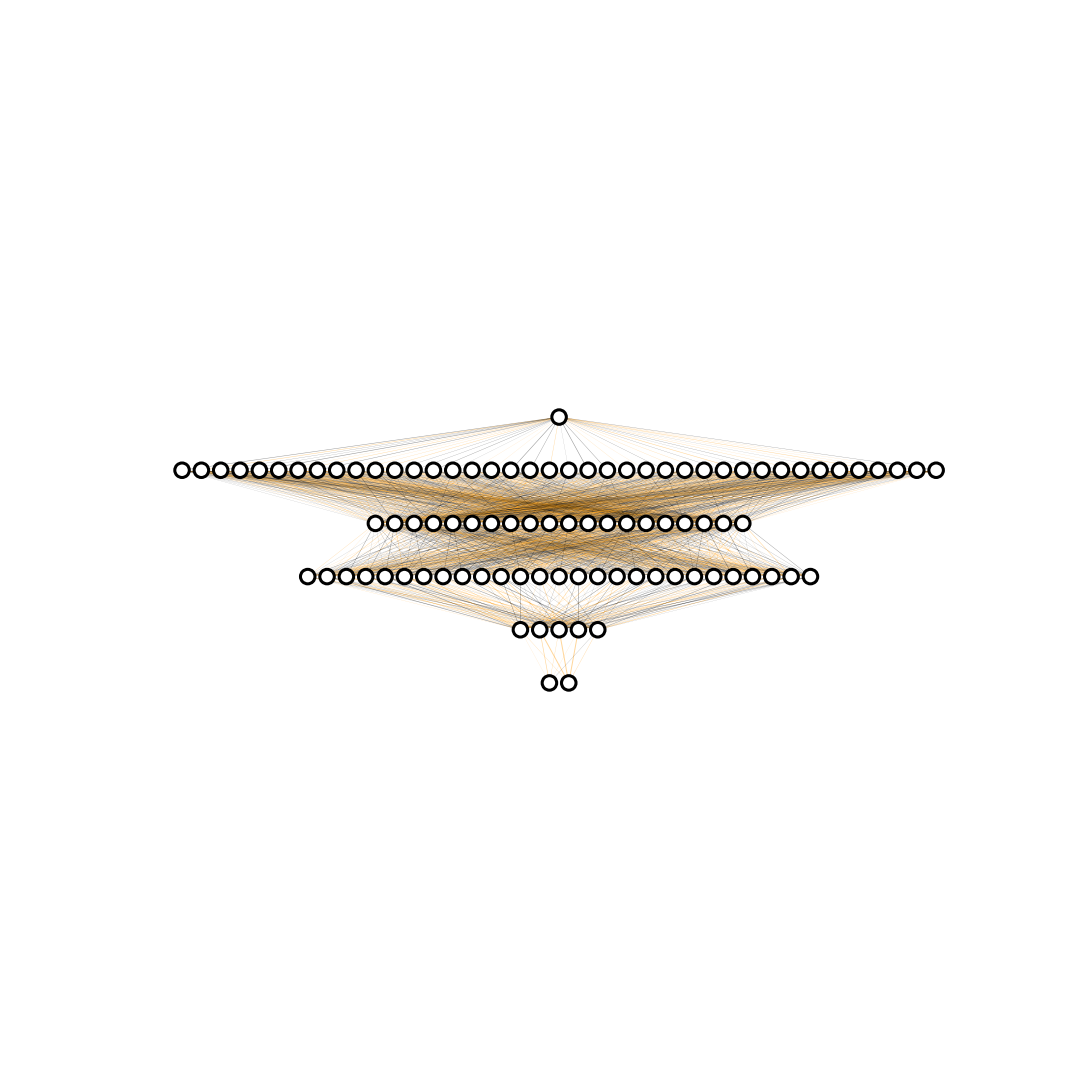

In [59]:
nnViz_mxnet.visualize_model(mod)

Model structure [loosely] inspired by NVIDIA's new HQ ;]  
http://c.ymcdn.com/sites/aiascv.org/resource/resmgr/meeting_images/2017/March/Nv2.jpeg

# Train Model Loop [ no visualization ]

In [60]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [61]:
import time
startTime = time.time()
for epoch in range(300):
    
    trainIterator.reset()
    metric.reset()
    
    for batch in trainIterator:
        
        mod.forward( batch, is_train = True )       # compute predictions
        mod.update_metric( metric, batch.label )    # accumulate prediction accuracy
        mod.backward()                              # compute gradients
        mod.update()                                # update parameters
    
    print('Epoch %d, Training %s' % (epoch, metric.get()))
elapsedTime = time.time() - startTime
print(elapsedTime)

Epoch 0, Training ('rmse', 0.2928433954715729)
Epoch 1, Training ('rmse', 0.21751266494393348)
Epoch 2, Training ('rmse', 0.21361418217420577)
Epoch 3, Training ('rmse', 0.20793066471815108)
Epoch 4, Training ('rmse', 0.1959237426519394)
Epoch 5, Training ('rmse', 0.17389938011765479)
Epoch 6, Training ('rmse', 0.16359264105558396)
Epoch 7, Training ('rmse', 0.15597025007009507)
Epoch 8, Training ('rmse', 0.14953361898660661)
Epoch 9, Training ('rmse', 0.1458767533302307)
Epoch 10, Training ('rmse', 0.14448502659797668)
Epoch 11, Training ('rmse', 0.14408394843339919)
Epoch 12, Training ('rmse', 0.14379230067133902)
Epoch 13, Training ('rmse', 0.14326087310910224)
Epoch 14, Training ('rmse', 0.1422317810356617)
Epoch 15, Training ('rmse', 0.14104247391223906)
Epoch 16, Training ('rmse', 0.14005700051784514)
Epoch 17, Training ('rmse', 0.13908618912100792)
Epoch 18, Training ('rmse', 0.13802767992019654)
Epoch 19, Training ('rmse', 0.1368585243821144)
Epoch 20, Training ('rmse', 0.13561

Epoch 168, Training ('rmse', 0.064027527719736105)
Epoch 169, Training ('rmse', 0.063870988786220551)
Epoch 170, Training ('rmse', 0.063715702109038833)
Epoch 171, Training ('rmse', 0.063562283664941793)
Epoch 172, Training ('rmse', 0.06341049019247294)
Epoch 173, Training ('rmse', 0.063259252533316615)
Epoch 174, Training ('rmse', 0.063108529895544052)
Epoch 175, Training ('rmse', 0.06295913718640804)
Epoch 176, Training ('rmse', 0.062811626307666305)
Epoch 177, Training ('rmse', 0.062665870040655131)
Epoch 178, Training ('rmse', 0.062520707398653036)
Epoch 179, Training ('rmse', 0.06237622257322073)
Epoch 180, Training ('rmse', 0.062233186140656468)
Epoch 181, Training ('rmse', 0.062091848626732823)
Epoch 182, Training ('rmse', 0.061952173709869385)
Epoch 183, Training ('rmse', 0.061813604459166525)
Epoch 184, Training ('rmse', 0.061675443500280383)
Epoch 185, Training ('rmse', 0.061538299545645714)
Epoch 186, Training ('rmse', 0.061403787508606908)
Epoch 187, Training ('rmse', 0.061

# Train Model + Visualize

In [62]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [67]:

NEpochs = 350
displayUpdateInterval = 10


currentNN = {}
plotCount = 0

xOffset = np.zeros( (trainData.shape[0], 1))
yOffset = np.zeros( (trainData.shape[0], 1))
zOffset = np.zeros( (trainData.shape[0], 1))

xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2; yModifier = 0; zModifier = 0; 
plotCount = 0

evalLoss = np.empty((NEpochs))
evalLoss[:] = np.NaN

predictIterator.reset()
nextIterData = predictIterator.next()
batchInputs = nextIterData.data[0].asnumpy()

# 3D plot
plot = k3d.plot()
zScaling, offset = plot_3D_data(plot)
plot.display()

# train 5 epochs, i.e. going over the data iter one pass
for iEpoch in range(NEpochs):
    
    trainIterator.reset()
    metric.reset()
    
    for batch in trainIterator:
        mod.forward( batch, is_train = True )     # compute predictions
        mod.update_metric( metric, batch.label )  # accumulate prediction accuracy
        mod.backward()                            # compute gradients
        mod.update()                              # update parameters
    
    evalLoss[iEpoch] = metric.get()[1]
    print('Epoch: %d, Training Loss: %s' % ( iEpoch, evalLoss[iEpoch] ))
    
    
    # plotting 
    if iEpoch % displayUpdateInterval == 0:
        
        mod.forward( nextIterData )
        
        currentNN[plotCount] = mod.get_outputs()[0].asnumpy()

        comboOffset = np.hstack( (xOffset + xModifier, yOffset + yModifier, zOffset + zModifier) )
        plot += k3d.points ( np.hstack( ( batchInputs, currentNN[plotCount] * zScaling) ) + comboOffset + offset, color=0xA9A9FF, point_size = .2, shader = 'flat' )        
        #plot += K3D.text ( str( round( evalLoss[iEpoch], 4 )), 
        #                  (comboOffset + offset + (0, 0, 3)), color=0xff00ff, size=.5, reference_point='rb')
        
        
        plotCount += 1
        if plotCount % 8 == 0:
            xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2
            yModifier -= 1 * np.abs(yRange[1]-yRange[0])*1.2
        else:
            xModifier += 1 * np.abs(xRange[1]-xRange[0])*1.2

-50.0
-40.0
50.0
60.0


Output()

Epoch: 0, Training Loss: 0.211587837338
Epoch: 1, Training Loss: 0.211034405231
Epoch: 2, Training Loss: 0.210436980426
Epoch: 3, Training Loss: 0.20912142247
Epoch: 4, Training Loss: 0.206945684552
Epoch: 5, Training Loss: 0.20334642455
Epoch: 6, Training Loss: 0.197315835208
Epoch: 7, Training Loss: 0.188111273199
Epoch: 8, Training Loss: 0.177669151127
Epoch: 9, Training Loss: 0.17073989436
Epoch: 10, Training Loss: 0.167044563591
Epoch: 11, Training Loss: 0.163718564808
Epoch: 12, Training Loss: 0.160223416984
Epoch: 13, Training Loss: 0.156438987702
Epoch: 14, Training Loss: 0.152727553248
Epoch: 15, Training Loss: 0.149714246392
Epoch: 16, Training Loss: 0.147432553768
Epoch: 17, Training Loss: 0.145445492119
Epoch: 18, Training Loss: 0.143520800769
Epoch: 19, Training Loss: 0.141666962951
Epoch: 20, Training Loss: 0.140002387762
Epoch: 21, Training Loss: 0.138584152609
Epoch: 22, Training Loss: 0.137305060774
Epoch: 23, Training Loss: 0.136074621975
Epoch: 24, Training Loss: 0.1

Epoch: 196, Training Loss: 0.0508276283741
Epoch: 197, Training Loss: 0.0509494686499
Epoch: 198, Training Loss: 0.0513026345521
Epoch: 199, Training Loss: 0.0518671056256
Epoch: 200, Training Loss: 0.0525374878198
Epoch: 201, Training Loss: 0.052983949706
Epoch: 202, Training Loss: 0.0530232517049
Epoch: 203, Training Loss: 0.0527978863567
Epoch: 204, Training Loss: 0.0525908397511
Epoch: 205, Training Loss: 0.052499721013
Epoch: 206, Training Loss: 0.0524305658415
Epoch: 207, Training Loss: 0.0523125585169
Epoch: 208, Training Loss: 0.0521697187796
Epoch: 209, Training Loss: 0.0520440375432
Epoch: 210, Training Loss: 0.0519371496513
Epoch: 211, Training Loss: 0.0518303610384
Epoch: 212, Training Loss: 0.0517158428207
Epoch: 213, Training Loss: 0.0516003008932
Epoch: 214, Training Loss: 0.0514897961169
Epoch: 215, Training Loss: 0.051383337751
Epoch: 216, Training Loss: 0.0512773962691
Epoch: 217, Training Loss: 0.0511710170656
Epoch: 218, Training Loss: 0.0510656638071
Epoch: 219, Tr

<IPython.core.display.Javascript object>


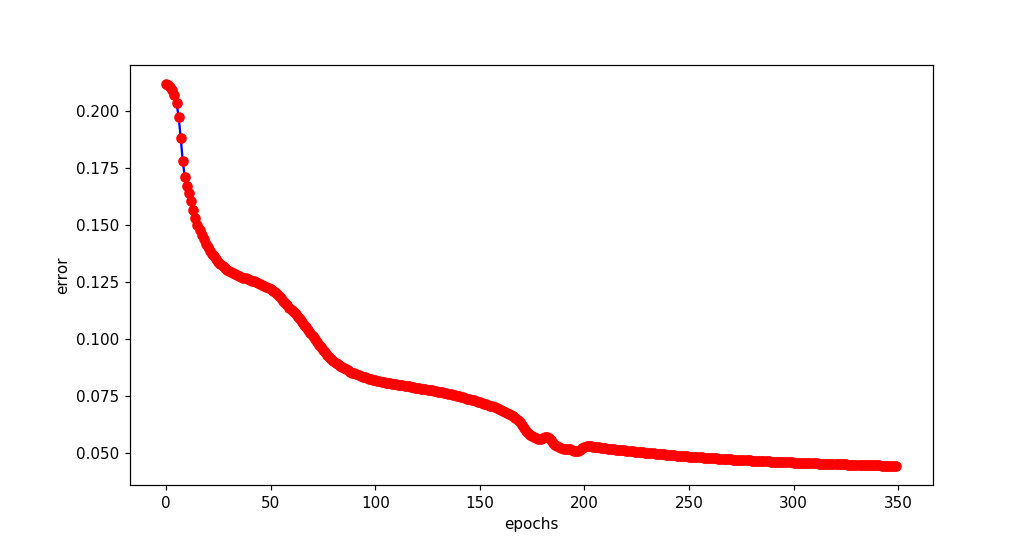

Text(0,0.5,'error')

In [68]:
plt.figure()
plt.plot(evalLoss[:], 'b')
plt.plot(evalLoss[:], 'or')
plt.xlabel('epochs')
plt.ylabel('error')

# Plot Predictions Before Training

In [70]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( batchInputs, currentNN[0]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,3) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

# Plot Predictions Midway Through Training

In [ ]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( batchInputs, currentNN[int(plotCount/2)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,3) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

# Plot Predictions at End of Training

In [ ]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( batchInputs, currentNN[int(plotCount-1)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,3) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

## thanks!